In [1]:
import pandas as pd 
from pandas import Series
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.api import qqplot  
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 

import pmdarima as pm
from pmdarima import auto_arima 
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn import datasets

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
#Importing data
Guangzhou = pd.read_csv("D:/Math546 Time series/final projects/PM2.5 Data of Five Chinese Cities Data Set/GuangzhouPM20100101_20151231.csv")


In [3]:
#Delet non-useful data
##Beijing.drop(['PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'season', 'precipitation', 'Iprec'], 
##               axis=1,
##              inplace=True)

In [4]:
Guangzhou.dropna(axis=0, how="any",inplace=True)

In [5]:
# from datetime import datetime
Guangzhou['Time'] = pd.to_datetime(Guangzhou['year'].map(str) +"/"+ Guangzhou['month'].map(str) +"/"+ Guangzhou['day'].map(str)+" "+Guangzhou['hour'].map(str)+":00:00")
#Beijing

In [6]:
Guangzhou.groupby(['year']).size()

year
2013    3863
2014    7884
2015    8327
dtype: int64

In [7]:
by_hour = Guangzhou.groupby(['Time']).mean()
#by_hour.head()

In [8]:
by_hour.index = pd.to_datetime(by_hour.index, 
                             format='%d-%m-%Y %H:%M:%S')
by_hour = by_hour.set_index(by_hour.index).asfreq('H')
by_hour = by_hour.fillna(method='ffill')

#print(by_hour.index)

In [9]:
by_hour['Time'] = by_hour.index
#by_hour['Time']

In [10]:
data_13 = by_hour[(by_hour['Time'] >=pd.to_datetime('20140101030000')) & (by_hour['Time'] <= pd.to_datetime('20151231030000'))]

In [11]:
data_13 = data_13.set_index(data_13.index).asfreq('H')
data_13 = data_13.fillna(method='ffill')
#data_13

In [12]:
#data_13.to_csv(r'D:/Math546 Time series/project/Prep_FiveCitiePMData_MEAN/GuangzhouPM_cleaned.csv')

In [38]:
data = by_hour[(by_hour['Time'] >=pd.to_datetime('20140101030000')) & (by_hour['Time'] <= pd.to_datetime('20140201030000'))]
data = data.set_index(data.index).asfreq('H')
data = data.fillna(method='ffill')
#data

In [15]:
# take aDFuller test the statioinarity of  the timeseries
def test_stationarity(timeseries):
 #Determing rolling statistics
    rolmean=pd.Series.rolling(timeseries,window=12).mean()
 #rolmean=pd.rolling_mean(timeseries,window=12)
 #rolstd=pd.rolling_std(timeseries,window=12)
    rolstd=pd.Series.rolling(timeseries,window=12).std()
 
 #plot rolling statistics
    orig=plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(rolmean,color='red',label='Rolling mean')
    std=plt.plot(rolstd,color='black',label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean & Standard Deviatiom')
    plt.show(block=False)
 
 #perfprmance Dickey_Fuller Test
    print('Resluts of Dickey-Fuller Test:')
    dftest=adfuller(timeseries,autolag='AIC')
    dfountput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','Number of obervations used'])
 
    for key,value in dftest[4].items():
        dfountput['Critical Value(%s)'%key]=value      
    print(dfountput)
# 

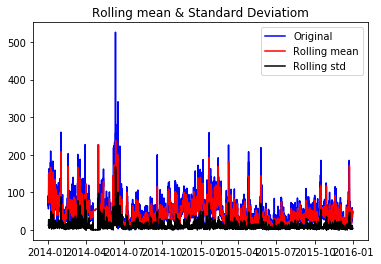

Resluts of Dickey-Fuller Test:
Test Statistic               -1.046764e+01
p-value                       1.309098e-18
#lags used                    4.400000e+01
Number of obervations used    1.745200e+04
Critical Value(1%)           -3.430725e+00
Critical Value(5%)           -2.861706e+00
Critical Value(10%)          -2.566858e+00
dtype: float64


In [16]:
test_stationarity(data_13['PM_US Post'])

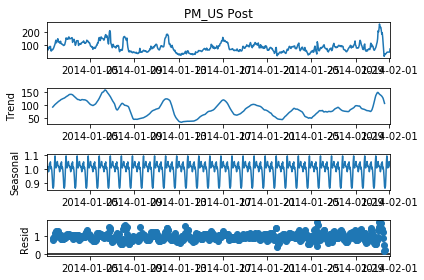

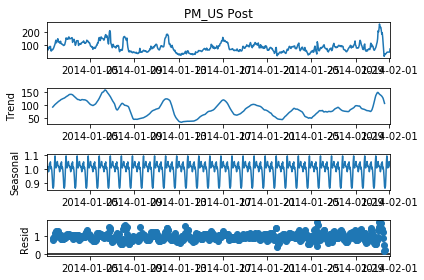

In [39]:
result = seasonal_decompose(data['PM_US Post'],  
                            model ='multiplicative') 
  
# ETS plot  
result.plot()

In [24]:
len(data_13)

17497

In [25]:
# Split data into train / test sets 
train = data_13['PM_US Post'].iloc[:len(data_13)-4000] 
test = data_13['PM_US Post'].iloc[len(data_13)-4000:]

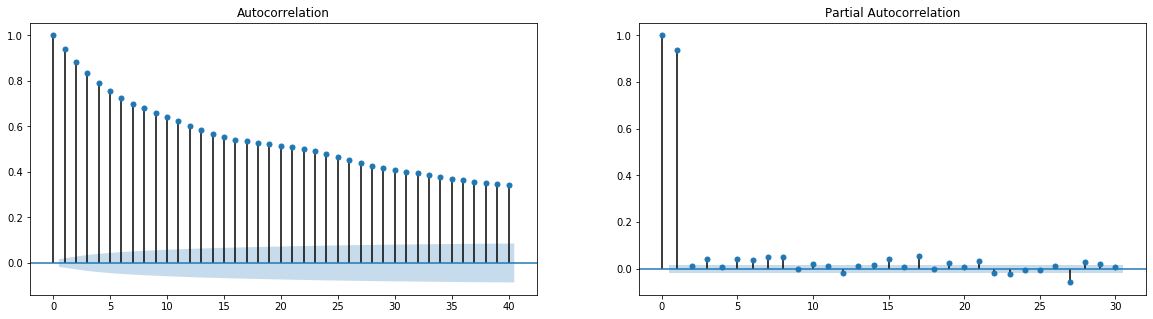

In [26]:
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_acf(train, lags=40, ax=axes[0], fft=False)
plot_pacf(train, lags=30, ax=axes[1])
plt.show()

In [27]:
# Fit auto_arima function to dataset 
stepwise_fit = auto_arima(train, start_p = 0, start_q = 0, 
                          max_p = 2, max_q = 4, m=7,
                          start_P = 0, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise  

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 1, 1, 7) (constant=True); AIC=126260.349, BIC=126282.878, Time=4.574 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 7) (constant=True); AIC=128033.353, BIC=128048.373, Time=0.506 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 7) (constant=True); AIC=111341.246, BIC=111371.284, Time=6.305 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 7) (constant=True); AIC=116738.155, BIC=116768.194, Time=8.133 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 7) (constant=False); AIC=128031.361, BIC=128038.871, Time=0.300 seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 0, 7) (constant=True); AIC=114919.398, BIC=114941.927, Time=1.143 seconds
Fit ARIMA: (1, 0, 0)x(2, 1, 0, 7) (constant=True); AIC=109415.047, BIC=109452.595, Time=22.157 seconds
Fit ARIMA: (1, 0, 0)x(2, 1, 1, 7) (constant=True); AIC=106054.483, BIC=106099.541, Time=77.687 seconds
Near non-invertible roots for order (1, 0, 0)(2, 1, 1, 7); setting score to inf (at least one inverse root too close to the border of the 

In [28]:
# To print the summary 
stepwise_fit.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                13497
Model:             SARIMAX(1, 0, 0)x(2, 1, [1], 7)   Log Likelihood              -53021.241
Date:                             Tue, 14 Apr 2020   AIC                         106054.483
Time:                                     22:16:17   BIC                         106099.541
Sample:                                          0   HQIC                        106069.510
                                           - 13497                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0009      0.000     -2.933      0.003      -0.002      -0.000
ar.L1          0.9402      0.001    742.212      0.000       0.938       0.943
ar.S.L7       -0.0270      0.003     -9.369      0.000      -0.033      -0.021
ar.S.L14      -0.0242      0.005     -4.857      0.000      -0.034      -0.014
ma.S.L7       -0.9993      0.001   -696.432      0.000      -1.002      -0.996
sigma2       151.3403      0.344    439.738      0.000     150.666     152.015
===================================================================================
Ljung-Box (Q):                      278.13   Jarque-Bera (JB):           6984005.05
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             1.35
Prob(H) (two-sided):                  0.00   Kurtosis:                       114.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
# Fit a SARIMAX(1, 0, 0)x(2, 1, [1], 7)on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train,  
                order = (1, 0, 0),  
                seasonal_order =(2, 1, [1], 7))

In [43]:
result = model.fit() 

In [44]:
 result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          PM_US Post   No. Observations:                13497
Model:             SARIMAX(1, 0, 0)x(2, 1, [1], 7)   Log Likelihood              -53022.301
Date:                             Tue, 14 Apr 2020   AIC                         106054.601
Time:                                     22:22:18   BIC                         106092.150
Sample:                                 01-01-2014   HQIC                        106067.125
                                      - 07-17-2015                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9347      0.001    816.304      0.000       0.932       0.937
ar.S.L7       -0.0272      0.003     -8.855      0.000      -0.033      -0.021
ar.S.L14      -0.0251      0.005     -4.999      0.000      -0.035      -0.015
ma.S.L7       -0.9937      0.001   -911.959      0.000      -0.996      -0.992
sigma2       151.5309      0.273    555.159      0.000     150.996     152.066
===================================================================================
Ljung-Box (Q):                      267.63   Jarque-Bera (JB):           6924013.00
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                       113.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

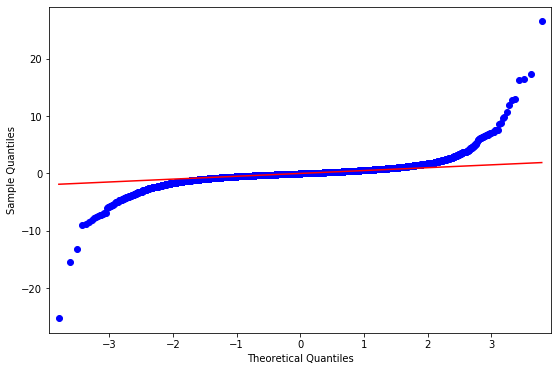

In [45]:
resid = result.resid
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

In [46]:
test_split = data_13['PM_US Post'].iloc[len(data_13)-300:]

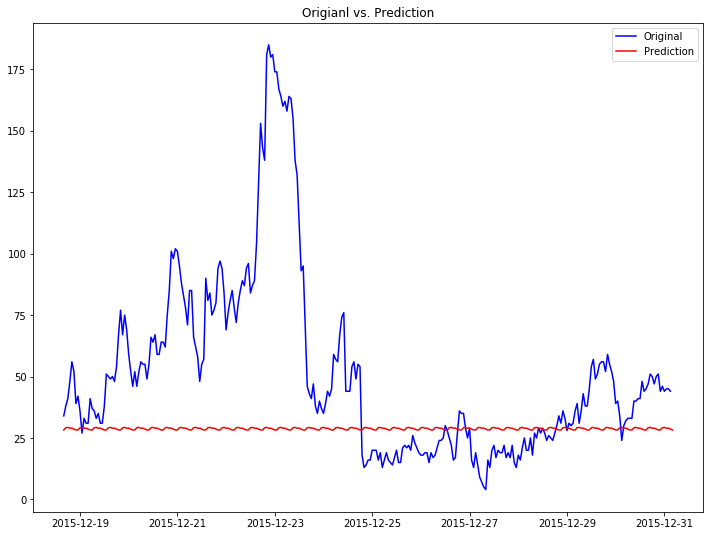

In [48]:
predict_ARMA = result.predict(start =17197, end = 17497) 
#print(predict_ARIMA) 

plt.figure(figsize=(12,9)) 
orig = plt.plot(test_split, color='blue', label='Original') 
pred = plt.plot(predict_ARMA, color='red', label='Prediction' ) 
plt.legend(loc='best') 
plt.title('Origianl vs. Prediction') 
plt.show(block=False) 